In [1]:
import json
import pandas as pd
from difflib import SequenceMatcher
from tqdm import tnrange, tqdm_notebook

In [2]:
with open('data/videos/20200504-193926_joe_biden.json') as file:
    data = json.loads(file.read())

In [3]:
with open('data/media_bias.json') as file:
    media_bias = json.loads(file.read())

In [4]:
max = 0
for row in data:
    this_len = len(row[list(row.keys())[0]]['recommendations'])
    if this_len > max:
        max = this_len

In [5]:
columns = ['id', 'title', 'genre', 'views', 'likes', 'dislikes', 'description', 'duration', 
           'datePublished', 'uploadDate', 'key', 'channel', 'channel_url', 'channel_id', 
           'recommendation1', 'recommendation2', 'recommendation3', 
           'recommendation4', 'recommendation5', 'recommendation6']

In [6]:
def get_recommendation(row, no):
    try:
        return row['recommendations'][no]
    except:
        return None

In [7]:
df = pd.DataFrame([], columns=columns)
for row in tqdm_notebook(data):
    this_row = row[list(row.keys())[0]]
    df = df.append({
        'id': list(row.keys())[0],
        'title': this_row['title'],
        'genre': this_row['genre'],
        'views': this_row['views'],
        'likes': this_row['likes'],
        'dislikes': this_row['dislikes'],
        'description': this_row['description'],
        'duration': this_row['duration'],
        'datePublished': this_row['datePublished'],
        'uploadDate': this_row['uploadDate'],
        'key': this_row['key'],
        'channel': this_row['channel'],
        'channel_url': this_row['channel_url'],
        'channel_id': this_row['channel_id'],
        'recommendation1': get_recommendation(this_row, 0),
        'recommendation2': get_recommendation(this_row, 1),
        'recommendation3': get_recommendation(this_row, 2),
        'recommendation4': get_recommendation(this_row, 3),
        'recommendation5': get_recommendation(this_row, 4),
        'recommendation6': get_recommendation(this_row, 5),
    }, ignore_index=True)

In [8]:
similar = {}
for channel in tqdm_notebook(df['channel'].unique()):
    ratio = 0
    if channel == None:
        continue
    for bias in media_bias.keys():
        this_ratio = SequenceMatcher(None, channel, bias.strip()).ratio()
        if this_ratio > ratio:
            ratio = this_ratio
            similar[channel] = {
                'media': bias.strip(),
                'bias': media_bias[bias],
                'similarity': this_ratio
            }

In [9]:
similar_df = pd.DataFrame([], columns=['channel', 'media', 'bias', 'similarity'])
for row in similar.keys():
    similar_df = similar_df.append({
        'channel': row,
        'media': similar[row]['media'],
        'bias': similar[row]['bias'],
        'similarity': similar[row]['similarity'],
    }, ignore_index=True)
similar_df.to_csv('data/similarity.csv') # Modify manually and reload

In [10]:
similar_df = pd.read_csv('data/similarity.csv', index_col=0)

In [11]:
df = df.merge(similar_df, on='channel')

In [13]:
df_dict = {}
for i, row in df.iterrows():
    df_dict[row['id']] = row['bias']

In [69]:
df_calculations = {i: {
    'Self': None,
    'Left': 0,
    'Right': 0,
    'Right-Center': 0,
    'Left-Center': 0,
    'Least Biased': 0,
    'Questionable': 0,
    'Pro Science': 0,
    'Satire': 0,
    'Conspiracy-Pseudoscience': 0,
} for i in df['id'].unique()}

for row in data:
    this_id = list(row.keys())[0]
    try:
        this_bias = df_dict[this_id]
    except Exception as e:
        this_bias = None
    try:
        if df_calculations[this_id]['Self'] == None:
            df_calculations[this_id]['Self'] = this_bias
            number_recommendations = 0
            for recommendation in row[this_id]['recommendations']:
                try:
                    that_bias = df_dict[recommendation]
                except Exception as e:
                    that_bias = None
                if that_bias != None:
                    df_calculations[this_id][that_bias] += 1
                    number_recommendations += 1
            for k in df_calculations[this_id].keys():
                if k != 'Self':
                    df_calculations[this_id][k] = df_calculations[this_id][k] / number_recommendations
    except:
        pass

In [71]:
final = pd.DataFrame([], columns=['Self', 'Left', 'Right', 'Right-Center', 'Left-Center', 'Least Biased', 'Questionable', 'Pro Science', 'Satire', 'Conspiracy-Pseudoscience'])
for row in df_calculations.keys():
    final = final.append(df_calculations[row], ignore_index=True)

In [72]:
final.to_csv('data/final.csv')

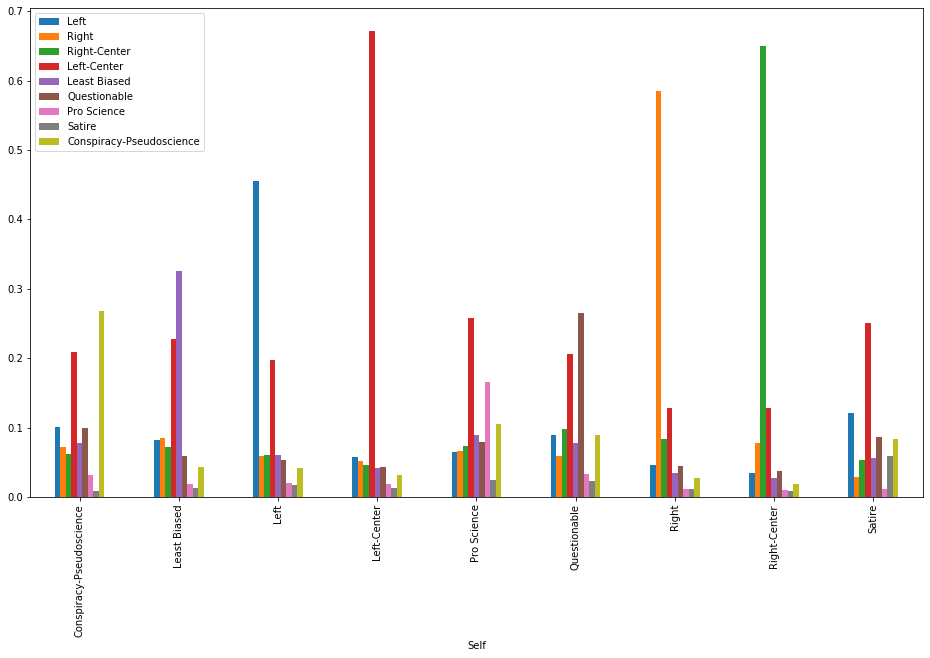

In [80]:
final.groupby(['Self']).mean().plot.bar(figsize=(16, 9))

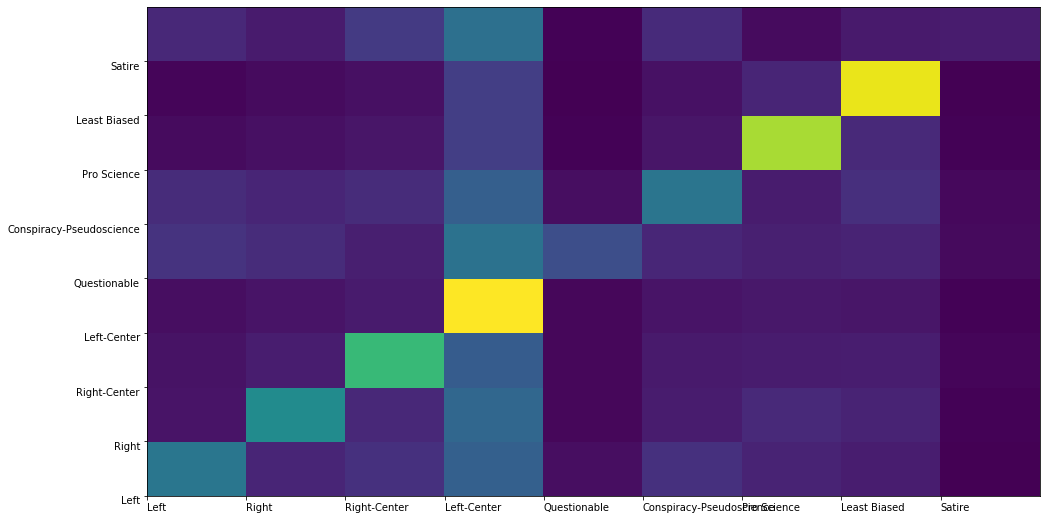

In [130]:
import numpy as np
plt.figure(figsize=(16, 9))
plt.pcolor(final.groupby(['Self']).mean()[final.groupby(['Self']).mean().index])
plt.yticks(np.arange(len(final['Self'].unique())), final['Self'].unique(), verticalalignment='top')
plt.xticks(np.arange(len(final['Self'].unique())), final['Self'].unique(), horizontalalignment='left')
plt.show()